In [1]:
# import numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# import matplotlib for data visulization
import matplotlib.pyplot as plt

# import os to read system directory
import os

# import re for string manipulation
import re

# import module to control the size of figure
from IPython.core.pylabtools import figsize

# import train_test_split to split the data into training set and validating set, 
# RandomizedSearchCV for cross validation and GridSearchCV for hyperparameters tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# import MinMaxScaler to normalize the data and OneHotEncoder to encode the categorical features as one-hot numeric arrays
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# import SimpleImputer to impute missing values
from sklearn.impute import SimpleImputer 

# import different classification methods of machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# import accuracy_score to measure the performance of a specific method
from sklearn.metrics import accuracy_score

In [2]:
# get the current working directory
path=os.getcwd()
# read the training data
train_data_full = pd.read_csv(path+'/train.csv')
# display the first 10 rows of the training data
train_data_full.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
# get an overview of the training data
train_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# the training data contains both numerical and categorical data, from which we can see there are missing values for features 'Age', 'Cabin' and 'Embarked' which we will deal with later

In [4]:
# Split the features and target from the training data
X_full = train_data_full.drop(columns=['Survived'])
y_full = train_data_full.Survived

In [5]:
# find those features which contains more than 50% missing values and then drop those features
drop_cols = [col for col in X_full.columns if X_full[col].isnull().sum()/len(X_full[col]) > 0.5]
X_full = X_full.drop(columns=drop_cols)
print(drop_cols)

['Cabin']


In [6]:
# find the titles of the passagers from feature 'Name' and assign them as the new feature 'title'
X_full['Title'] = np.zeros(X_full.shape[0])
for i in range(X_full.shape[0]):
    X_full['Title'][i] = re.findall(r'\b\w*\.', X_full['Name'][i])[0]

In [7]:
# Splitting the training data into training set and validating set
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2, random_state=42)

In [8]:
# find the numerical columns
numerical_columns = [col for col in X_train_full.columns if X_train_full[col].dtype in ['int64', 'float64']]
print(numerical_columns)

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [9]:
# find the categorical columns
categorical_columns = [col for col in X_train_full.columns if X_train_full[col].dtype=='object']
print(categorical_columns)

['Name', 'Sex', 'Ticket', 'Embarked', 'Title']


In [10]:
# find those features with high cardinality. i.e. more than 100 unique values for a given feature
categorical_columns = [col for col in categorical_columns if pd.Series(X_train_full[col].unique()).value_counts().sum() <= 100]
print(categorical_columns)

['Sex', 'Embarked', 'Title']


In [11]:
# combine the numerical features and categorical features
my_cols = numerical_columns + categorical_columns
print(my_cols)

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked', 'Title']


In [12]:
# get a copy of X_train and X_valid for the selected features
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [13]:
# create two imputers to impute the missing values of categorical features and numerical features
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer(strategy='median')

In [14]:
# impute the missing values
X_train_cat = pd.DataFrame(imputer_cat.fit_transform(X_train[categorical_columns]), columns=categorical_columns)
X_train_num = pd.DataFrame(imputer_num.fit_transform(X_train[numerical_columns]), columns=numerical_columns)
X_valid_cat = pd.DataFrame(imputer_cat.transform(X_valid[categorical_columns]), columns=categorical_columns)
X_valid_num = pd.DataFrame(imputer_num.transform(X_valid[numerical_columns]), columns=numerical_columns)

In [15]:
# check if there is no missing value after imputation
X_train_cat.isnull().sum().sum() + X_train_num.isnull().sum().sum() + X_valid_cat.isnull().sum().sum() + X_valid_num.isnull().sum().sum() == 0

True

In [16]:
# create a one-hot encoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [17]:
# encode the categorical features as one-hot arrays
X_train_cat_oh = OH_encoder.fit_transform(X_train_cat)
X_valid_cat_oh = OH_encoder.transform(X_valid_cat)
OH_column_names = OH_encoder.get_feature_names(categorical_columns)

In [18]:
# transform them into DataFrame
X_train_cat_OH = pd.DataFrame(X_train_cat_oh, columns=OH_column_names)
X_valid_cat_OH = pd.DataFrame(X_valid_cat_oh, columns=OH_column_names)

In [19]:
# combine the numerical and categorical features
X_train_OH = pd.concat([X_train_num, X_train_cat_OH], axis=1)
X_valid_OH = pd.concat([X_valid_num, X_valid_cat_OH], axis=1)

In [20]:
# print the shapes of the training and validating sets
print(X_train_OH.shape, X_valid_OH.shape, y_train.shape, y_valid.shape)

(712, 25) (179, 25) (712,) (179,)


In [21]:
# Normalize the data to the range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_final = scaler.fit_transform(X_train_OH)
X_valid_final = scaler.transform(X_valid_OH)

In [22]:
# Convert y to one-dimensional array
y_train_final = np.array(y_train).reshape((-1, ))
y_valid_final = np.array(y_valid).reshape((-1, ))

In [23]:
# function to quickly evaluate the performance for a given method with default settings
def fit_and_evaluate(model):
    model.fit(X_train_final, y_train_final)
    
    y_pred = model.predict(X_valid_final)
    model_score = accuracy_score(y_valid_final, y_pred)

    return model_score

In [24]:
# fit the data using Logistic Regression and print the accuracy of the prediction
lr = LogisticRegression()
lr_score = fit_and_evaluate(lr)
print(lr_score)

0.7988826815642458


In [25]:
# fit the data using Supporting Vector Classifier and print the accuracy of the prediction
svm = SVC(C=10, gamma=0.1, degree=4)
svm_score = fit_and_evaluate(svm)
print(svm_score)

0.8044692737430168


In [26]:
# fit the data using Random Forest Classifier and print the accuracy of the prediction
random_forest = RandomForestClassifier(random_state=42)
random_forest_score = fit_and_evaluate(random_forest)
print(random_forest_score)

0.8547486033519553


In [27]:
# fit the data using Decision Tree Classifier and print the accuracy of the prediction
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree_score = fit_and_evaluate(decision_tree)
print(decision_tree_score)

0.7541899441340782


In [28]:
# fit the data using k-Nearest  Classifier and print the accuracy of the prediction
knn = KNeighborsClassifier(n_neighbors=10)
knn_score = fit_and_evaluate(knn)
print(knn_score)

0.8044692737430168


In [29]:
# Number of trees used in the boosting process
n_estimators = [500, 1000, 1500, 2000, 2500]

# Maximum depth of each tree
max_depth = [3, 5, 10, 15, 20]

# Minimum number of samples per leaf
min_samples_leaf = [2, 4, 6, 8, 10]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10, 12, 15]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators':n_estimators, 'max_depth':max_depth, 'min_samples_leaf':min_samples_leaf,
                        'min_samples_split':min_samples_split, 'max_features':max_features}

In [30]:
# create a randomized search for the given hyperparameters
model = RandomForestClassifier()

random_cv = RandomizedSearchCV(estimator=model, param_distributions=hyperparameter_grid, cv=5, n_iter=25,
                                scoring='accuracy', n_jobs=-1, verbose=1, return_train_score = True, random_state=42)

In [31]:
# perform the randomized search with 5-fold cross validation
random_cv.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  4.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 10, 15, 20],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 4, 6, 10, 12,
                                                              15],
                                        'n_estimators': [500, 1000, 1500, 2000,
                                                         2500]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=1)

In [32]:
# output the best hyperparameters combination which achive highest accuracy
random_cv.best_estimator_

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=500)

In [33]:
# to further tune the hyperparameters, we use GridSearchCV to investigate the accuracy with repsect to the number of trees
trees_grid = {'n_estimators':[100, 300, 500, 700, 900, 1200, 1500]}

model = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=2,
                                min_samples_split=10, random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=trees_grid, cv=5, scoring='accuracy', 
                            verbose=1, n_jobs=-1, return_train_score=True)

In [34]:
# perform the grid search
grid_search.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   32.7s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=10, max_features='log2',
                                              min_samples_leaf=2,
                                              min_samples_split=10,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'n_estimators': [100, 300, 500, 700, 900, 1200, 1500]},
             return_train_score=True, scoring='accuracy', verbose=1)

Text(0.5, 1.0, 'Performance vs Number of Trees')

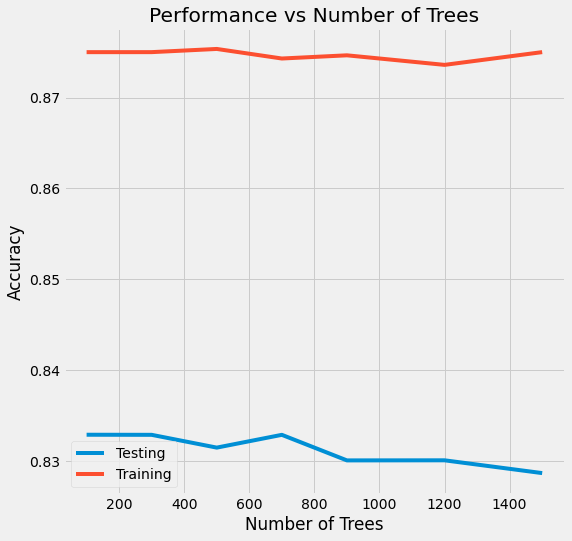

In [35]:
# visulize the results for different number of trees
results = pd.DataFrame(grid_search.cv_results_)

figsize(8,8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], results['mean_test_score'], label='Testing')
plt.plot(results['param_n_estimators'], results['mean_train_score'], label='Training')
plt.xlabel('Number of Trees'); plt.ylabel('Accuracy'); plt.legend()
plt.title('Performance vs Number of Trees')

In [36]:
# output the hyperparameters with best performance
final_model = grid_search.best_estimator_

final_model

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

In [37]:
# use the best model to fit the training data
# %%timeit -n 1 -r 5
final_model.fit(X_train_final, y_train_final)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

In [38]:
# read the test data
test_data_full = pd.read_csv(path+'/test.csv')

In [39]:
# find the titles of the passagers and assign them as new feature 'title'
test_data_full['Title'] = np.zeros(test_data_full.shape[0])
for i in range(test_data_full.shape[0]):
    test_data_full['Title'][i] = re.findall(r'\b\w*\.', test_data_full['Name'][i])[0]

In [40]:
# impute the missing values for the test data
X_test_cat = pd.DataFrame(imputer_cat.fit_transform(test_data_full[categorical_columns]), columns=categorical_columns)
X_test_num = pd.DataFrame(imputer_num.fit_transform(test_data_full[numerical_columns]), columns=numerical_columns)

In [41]:
# encode the categorical features as one hot arrays
X_test_cat_OH = pd.DataFrame(OH_encoder.transform(X_test_cat))

In [42]:
# combine the numerical and categorical features as a single DataFrame
X_test_OH = pd.concat([X_test_num, X_test_cat_OH], axis=1)

In [43]:
# normalize the test data
X_test_final = scaler.transform(X_test_OH)

In [44]:
# retrieve the passengers' Id
Id = test_data_full['PassengerId']

In [45]:
# use the best model to predict the result for the test data
y_test = final_model.predict(X_test_final)

In [46]:
res = pd.DataFrame(y_test, columns=['Survived'])

In [47]:
# export the result as a csv file
pd.concat([Id, res], axis=1).to_csv('predictions.csv', index=False)